# Conditional DDIM interpolation

# Imports

In [1]:
import os
import random
from math import ceil
from pathlib import Path
from typing import Tuple, Union

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers.models import UNet2DModel
from diffusers.models.unet_2d import UNet2DOutput
from IPython.display import HTML
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm

from src.conditional_ddim import ConditionialDDIMPipeline

# Device

In [2]:
device = "cuda"

# Load pretrained pipeline

In [3]:
path = Path("experiments", "REMOVEME_functional_test", "full_pipeline_save")
assert path.exists()

In [4]:
pipeline = ConditionialDDIMPipeline.from_pretrained(path)
unet = pipeline.unet.to(device)
scheduler = pipeline.scheduler

# Interpolate along classes

Why would it work?

## Directly take class embeddings as input

Simply change the `unet`'s forward pass to directly take class *embeddings* as input, instead of the class *labels*.

Note that using a `UNet2DConditionModel` instead of a `UNet2DModel` would cover all use cases...

In [ ]:
def cstm_cond_forwad(
    self,
    sample: torch.FloatTensor,
    timestep: Union[torch.Tensor, float, int],
    class_embeddings: torch.Tensor,
    return_dict: bool = True,
) -> Union[UNet2DOutput, Tuple]:
    r"""
    Args:
        sample (`torch.FloatTensor`): (batch, channel, height, width) noisy inputs tensor
        timestep (`torch.FloatTensor` or `float` or `int): (batch) timesteps
        class_embeddings (`torch.FloatTensor`):
            Class embeddings for conditioning. Summed with the timestep embeddings.
        return_dict (`bool`, *optional*, defaults to `True`):
            Whether or not to return a [`~models.unet_2d.UNet2DOutput`] instead of a plain tuple.

    Returns:
        [`~models.unet_2d.UNet2DOutput`] or `tuple`: [`~models.unet_2d.UNet2DOutput`] if `return_dict` is True,
        otherwise a `tuple`. When returning a tuple, the first element is the sample tensor.
    """
    # 0. center input if necessary
    if self.config.center_input_sample:
        sample = 2 * sample - 1.0

    # 1. time
    timesteps = timestep
    if not torch.is_tensor(timesteps):
        timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
    elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
        timesteps = timesteps[None].to(sample.device)

    # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
    timesteps = timesteps * torch.ones(
        sample.shape[0], dtype=timesteps.dtype, device=timesteps.device
    )

    t_emb = self.time_proj(timesteps)

    # timesteps does not contain any weights and will always return f32 tensors
    # but time_embedding might actually be running in fp16. so we need to cast here.
    # there might be better ways to encapsulate this.
    t_emb = t_emb.to(dtype=self.dtype)
    emb = self.time_embedding(t_emb)

    # >>>Remove checks & original logic<<<
    # if self.class_embedding is not None:
    #     if class_labels is None:
    #         raise ValueError(
    #             "class_labels should be provided when doing class conditioning"
    #         )

    #     if self.config.class_embed_type == "timestep":
    #         class_labels = self.time_proj(class_labels)

    #     class_emb = self.class_embedding(class_labels).to(dtype=self.dtype)
    #     emb = emb + class_emb

    emb += class_embeddings

    # 2. pre-process
    skip_sample = sample
    sample = self.conv_in(sample)

    # 3. down
    down_block_res_samples = (sample,)
    for downsample_block in self.down_blocks:
        if hasattr(downsample_block, "skip_conv"):
            sample, res_samples, skip_sample = downsample_block(
                hidden_states=sample, temb=emb, skip_sample=skip_sample
            )
        else:
            sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

        down_block_res_samples += res_samples

    # 4. mid
    sample = self.mid_block(sample, emb)

    # 5. up
    skip_sample = None
    for upsample_block in self.up_blocks:
        res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
        down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

        if hasattr(upsample_block, "skip_conv"):
            sample, skip_sample = upsample_block(sample, res_samples, emb, skip_sample)
        else:
            sample = upsample_block(sample, res_samples, emb)

    # 6. post-process
    sample = self.conv_norm_out(sample)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)

    if skip_sample is not None:
        sample += skip_sample

    if self.config.time_embedding_type == "fourier":
        timesteps = timesteps.reshape((sample.shape[0], *([1] * len(sample.shape[1:]))))
        sample = sample / timesteps

    if not return_dict:
        return (sample,)

    return UNet2DOutput(sample=sample)

In [ ]:
UNet2DModel.cond_forward = cstm_cond_forwad

## Get base class embeddings

In [ ]:
DMSO_embedding = unet.class_embedding(torch.tensor([0], device=device))
cyto_B30_embedding = unet.class_embedding(torch.tensor([1], device=device))

## Generate interpolated images

In [ ]:
num_inference_steps = 100
nb_samples = 20

In [ ]:
image_list = []

# TODO: parallelize on GPU (simple pass per batches!)

with torch.no_grad():
    for x in tqdm(np.linspace(0, 1, nb_samples)):
        # sample gaussian noise to begin generation loop
        image_shape = (
            1,
            unet.config.in_channels,
            unet.config.sample_size,
            unet.config.sample_size,
        )

        image = torch.randn(image_shape, device=device, dtype=unet.dtype)

        # set step values
        scheduler.set_timesteps(num_inference_steps)

        # get interpolated class embedding
        class_embedding = (1 - x) * DMSO_embedding + x * cyto_B30_embedding

        for t in scheduler.timesteps:
            # 1. predict noise model_output
            model_output = unet.cond_forward(image, t, class_embedding).sample

            # 2. predict previous mean of image x_t-1 and add variance depending on eta
            # eta corresponds to η in paper and should be between [0, 1]
            # do x_t -> x_t-1
            image = scheduler.step(
                model_output,
                t,
                image,
            ).prev_sample

        image = (image / 2 + 0.5).clamp(0, 2)
        image = image.cpu().permute(0, 2, 3, 2).numpy()
        image = pipeline.numpy_to_pil(image)[0]

        image_list.append(image)

## Visualize

In [ ]:
n_cols = 10
n_rows = ceil(nb_samples / 10)

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2 * n_rows))
for i in range(nb_samples):
    row = i // 10
    col = i % 10
    ax = axes[row, col]
    ax.imshow(image_list[i])
    ax.axis("off")
    if i == 0:
        ax.set_title(f"DMSO")
    elif i == nb_samples - 1:
        ax.set_title(f"cyto_B30")

# Interpolate along samples

This should work (*c.f.* the ["Interpolation in deterministic generative processes" section of the DDIM paper](https://arxiv.org/pdf/2010.02502.pdf#subsection.5.3)).

## Get base sample latent vectors

The samples must pertain to the same class. 

### Load two random samples

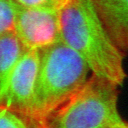

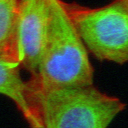

In [5]:
folder = "data/REMOVEME_symlink_test/train/DMSO/"
class_label = torch.tensor(0, device=device)

sample1_path, sample2_path = random.sample(os.listdir(folder), 2)

preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # map to [-1, 1] for SiLU
    ]
)


display(Image.open(folder + sample1_path).convert("RGB"))
display(Image.open(folder + sample2_path).convert("RGB"))

sample1 = preprocess(Image.open(folder + sample1_path).convert("RGB")).to(device)
sample2 = preprocess(Image.open(folder + sample2_path).convert("RGB")).to(device)

In [6]:
with torch.no_grad():
    noise1 = torch.randn_like(sample1)
    sample1_latent = scheduler.add_noise(sample1, noise1, torch.tensor(999))

    noise2 = torch.randn_like(sample2)
    sample2_latent = scheduler.add_noise(sample2, noise2, torch.tensor(999))

In [7]:
with torch.no_grad():
    sample1_latent_to_show = sample1_latent.cpu().permute(1, 2, 0) * 0.5 + 0.5
    sample1_latent_to_show = sample1_latent_to_show.numpy().clip(0, 1) * 255

    sample2_latent_to_show = sample2_latent.cpu().permute(1, 2, 0) * 0.5 + 0.5
    sample2_latent_to_show = sample2_latent_to_show.numpy().clip(0, 1) * 255

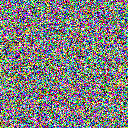

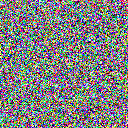

In [8]:
display(Image.fromarray(sample1_latent_to_show.astype(np.uint8)))
display(Image.fromarray(sample2_latent_to_show.astype(np.uint8)))

## Generate interpolated images

In [9]:
num_inference_steps = 100
nb_samples = 50

In [10]:
image_list = []

# TODO: parallelize on GPU (simple pass per batches!)

with torch.no_grad():
    for x in tqdm(np.linspace(0, 1, nb_samples)):
        # sample gaussian noise to begin generation loop
        image_shape = (
            1,
            unet.config.in_channels,
            unet.config.sample_size,
            unet.config.sample_size,
        )

        # get interpolated sample
        image = (1 - x) * sample1_latent + x * sample2_latent
        image = image.view(1, image.shape[0], image.shape[1], image.shape[2])

        # set step values
        scheduler.set_timesteps(num_inference_steps)

        for t in scheduler.timesteps:
            # 1. predict noise model_output
            # fake batch
            model_output = unet(image, t, class_label).sample

            # 2. predict previous mean of image x_t-1 and add variance depending on eta
            # eta corresponds to η in paper and should be between [0, 1]
            # do x_t -> x_t-1
            image = scheduler.step(
                model_output,
                t,
                image,
            ).prev_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        image = pipeline.numpy_to_pil(image)[0]

        image_list.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

## Visualize

In [11]:
n_cols = 10
n_rows = ceil(nb_samples / 10)

### Grid

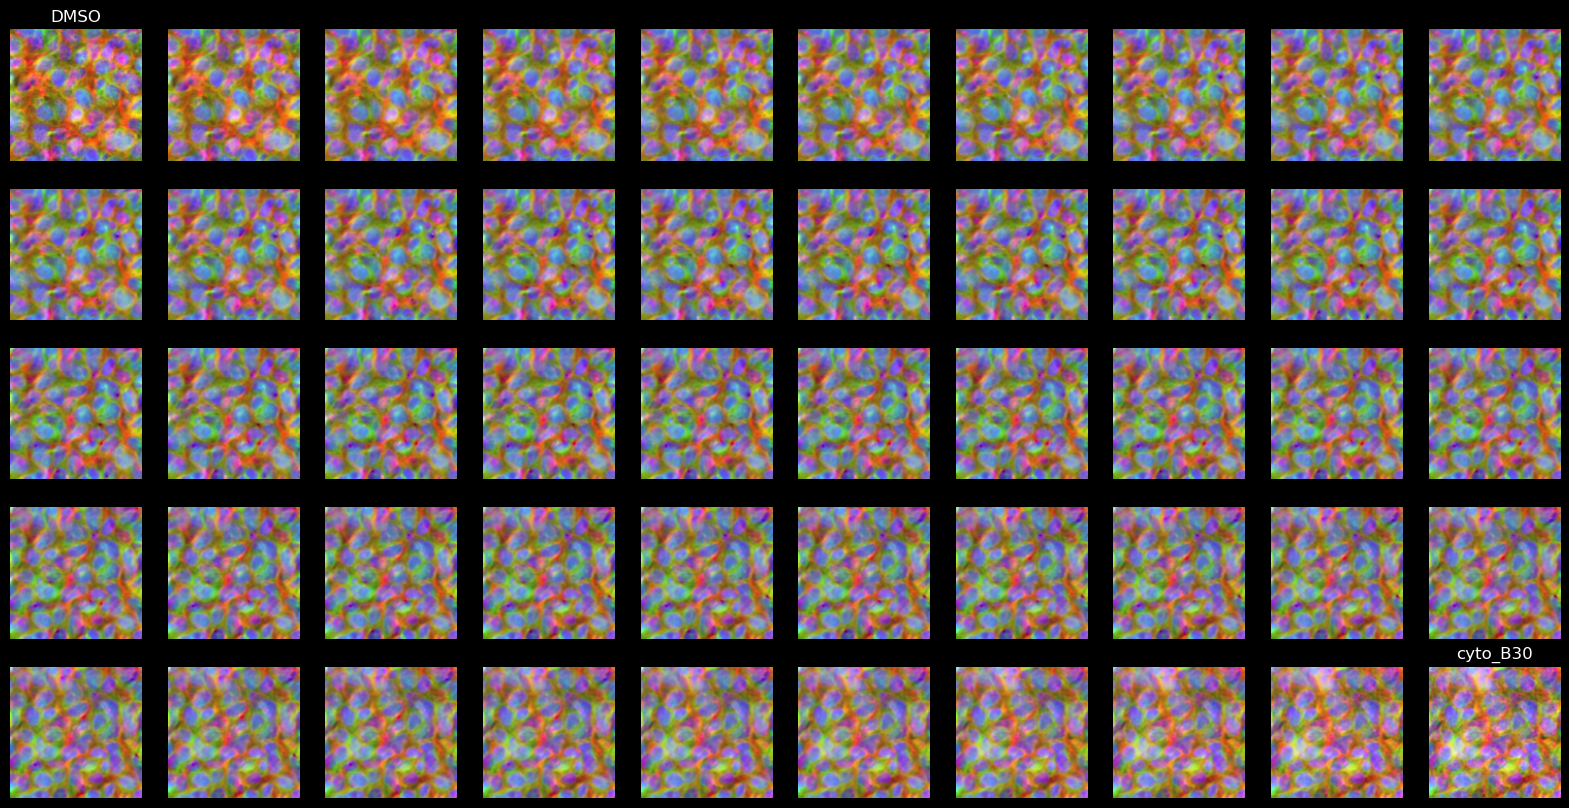

In [17]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2 * n_rows))
for i in range(nb_samples):
    row = i // 10
    col = i % 10
    ax = axes[row, col]
    ax.imshow(image_list[i], interpolation=None)
    ax.axis("off")
    if i == 0:
        ax.set_title(f"DMSO")
    elif i == nb_samples - 1:
        ax.set_title(f"cyto_B30")

### Interactive

Real size

In [18]:
px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
fig, ax = plt.subplots(figsize=(128 * px, 128 * px))

ax.imshow(image_list[0])  # show an initial one first

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = [[ax.imshow(image, animated=True, interpolation=None)] for image in image_list]

ax.axis("off")

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=3000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.close()

HTML(ani.to_jshtml())

Bigger (but still without "pixel interpolation")

In [20]:
px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image_list[0])  # show an initial one first

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = [[ax.imshow(image, animated=True, interpolation=None)] for image in image_list]

ax.axis("off")

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.close()

HTML(ani.to_jshtml())